In [1]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import loompy
import velocyto as vcy
import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42

/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2018-05-13 09:21:48,392 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown
2018-05-13 09:21:48,399 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
# plotting utility functions
def despline():
    ax1 = plt.gca()
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    
def minimal_xticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    xlims = np.linspace(start, end_, 5)
    xlims_tx = [""]*len(xlims)
    xlims_tx[0], xlims_tx[-1] = f"{xlims[0]:.0f}", f"{xlims[-1]:.02f}"
    plt.xticks(xlims, xlims_tx)

    
def minimal_yticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    ylims = np.linspace(start, end_, 5)
    ylims_tx = [""]*len(ylims)
    ylims_tx[0], ylims_tx[-1] = f"{ylims[0]:.0f}", f"{ylims[-1]:.02f}"
    plt.yticks(ylims, ylims_tx)

In [37]:
!mkdir data

In [39]:
from urllib.request import urlretrieve
urlretrieve("http://pklab.med.harvard.edu/velocyto/DentateGyrus/DentateGyrus.loom", "data/DentateGyrus.loom")

('data/DentateGyrus.loom', <http.client.HTTPMessage at 0x7ff714408898>)

# Load data

In [2]:
# Crate an analysis object
vlm = vcy.VelocytoLoom("data/DentateGyrus.loom")

In [4]:
# Read column attributes form the loom file and specify colors
vlm.ts = np.column_stack([vlm.ca["TSNE1"], vlm.ca["TSNE2"]])
colors_dict = {'RadialGlia': np.array([ 0.95,  0.6,  0.1]), 'RadialGlia2': np.array([ 0.85,  0.3,  0.1]), 'ImmAstro': np.array([ 0.8,  0.02,  0.1]),
              'GlialProg': np.array([ 0.81,  0.43,  0.72352941]), 'OPC': np.array([ 0.61,  0.13,  0.72352941]), 'nIPC': np.array([ 0.9,  0.8 ,  0.3]),
              'Nbl1': np.array([ 0.7,  0.82 ,  0.6]), 'Nbl2': np.array([ 0.448,  0.85490196,  0.95098039]),  'ImmGranule1': np.array([ 0.35,  0.4,  0.82]),
              'ImmGranule2': np.array([ 0.23,  0.3,  0.7]), 'Granule': np.array([ 0.05,  0.11,  0.51]), 'CA': np.array([ 0.2,  0.53,  0.71]),
               'CA1-Sub': np.array([ 0.1,  0.45,  0.3]), 'CA2-3-4': np.array([ 0.3,  0.35,  0.5])}
vlm.set_clusters(vlm.ca["ClusterName"], cluster_colors_dict=colors_dict)

2018-05-13 09:22:05,139 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=13.0 to DejaVu Sans ('/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-05-13 09:22:05,448 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


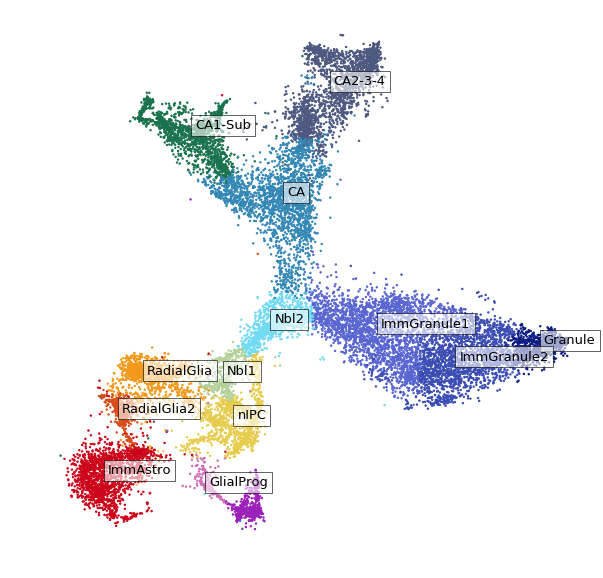

In [5]:
# Plot TSNE
plt.figure(figsize=(10,10))
vcy.scatter_viz(vlm.ts[:,0], vlm.ts[:,1], c=vlm.colorandum, s=2)
for i in range(max(vlm.ca["Clusters"])):
    ts_m = np.median(vlm.ts[vlm.ca["Clusters"] == i, :], 0)
    plt.text(ts_m[0], ts_m[1], str(vlm.cluster_labels[vlm.ca["Clusters"] == i][0]),
             fontsize=13, bbox={"facecolor":"w", "alpha":0.6})
plt.axis("off");

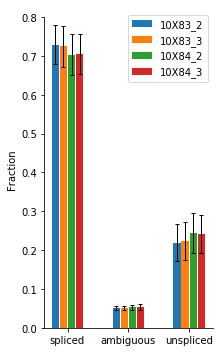

In [6]:
vlm.plot_fractions()

# Velocity Analysis

In [7]:
vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.4))

In [8]:
vlm.ts = np.column_stack([vlm.ca["TSNE1"], vlm.ca["TSNE2"]])

In [9]:
vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
vlm.filter_genes(by_detection_levels=True)

2018-05-13 09:22:17,656 - DEBUG - Filtering by detection level


2018-05-13 09:22:21,173 - DEBUG - svr_gamma set to 0.010838933448948623
2018-05-13 09:22:25,647 - DEBUG - Filtering by cv vs mean


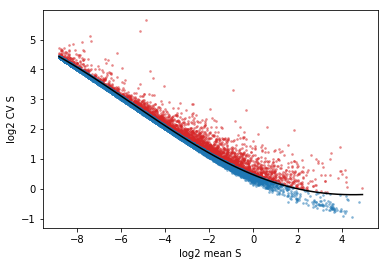

In [10]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

In [11]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0, min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.01, min_avg_S=0.08)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)

2018-05-13 09:22:26,062 - INFO - Cluster: CA (2295 cells)
2018-05-13 09:22:26,239 - INFO - Cluster: CA1-Sub (1647 cells)
2018-05-13 09:22:26,384 - INFO - Cluster: CA2-3-4 (2127 cells)
2018-05-13 09:22:26,556 - INFO - Cluster: GlialProg (227 cells)
2018-05-13 09:22:26,577 - INFO - Cluster: Granule (863 cells)
2018-05-13 09:22:26,645 - INFO - Cluster: ImmAstro (1786 cells)
2018-05-13 09:22:26,787 - INFO - Cluster: ImmGranule1 (2459 cells)
2018-05-13 09:22:26,979 - INFO - Cluster: ImmGranule2 (2098 cells)
2018-05-13 09:22:27,143 - INFO - Cluster: Nbl1 (410 cells)
2018-05-13 09:22:27,179 - INFO - Cluster: Nbl2 (1003 cells)
2018-05-13 09:22:27,259 - INFO - Cluster: OPC (595 cells)
2018-05-13 09:22:27,309 - INFO - Cluster: RadialGlia (1039 cells)
2018-05-13 09:22:27,393 - INFO - Cluster: RadialGlia2 (388 cells)
2018-05-13 09:22:27,426 - INFO - Cluster: nIPC (1203 cells)
2018-05-13 09:22:27,523 - DEBUG - Filtering by cluster expression
2018-05-13 09:22:27,524 - DEBUG - Filtering by detection 

In [12]:
# best with sample and expression scaling
vlm._normalize_S(relative_size=vlm.initial_cell_size,
                 target_size=np.mean(vlm.initial_cell_size))
vlm._normalize_U(relative_size=vlm.initial_Ucell_size,
                 target_size=np.mean(vlm.initial_Ucell_size))

19

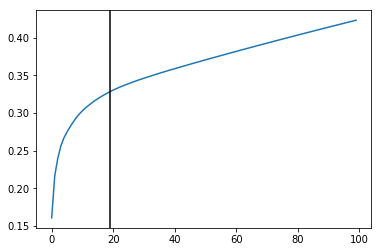

In [13]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
n_comps

In [14]:
k = 500
vlm.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

2018-05-13 09:22:33,348 - DEBUG - First search the 4000 nearest neighbours for 18140
2018-05-13 09:22:53,777 - DEBUG - Using the initialization network to find a 500-NN graph with maximum connectivity of 2000
2018-05-13 09:22:54,543 - DEBUG - Returning sparse matrix


In [15]:
vlm.fit_gammas(limit_gamma=False, fit_offset=False)

In [17]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

2018-05-13 11:48:57,793 - DEBUG - Assigning font /b'F1' = '/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2018-05-13 11:48:59,006 - DEBUG - Embedding font /data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2018-05-13 11:48:59,007 - DEBUG - Writing TrueType font.


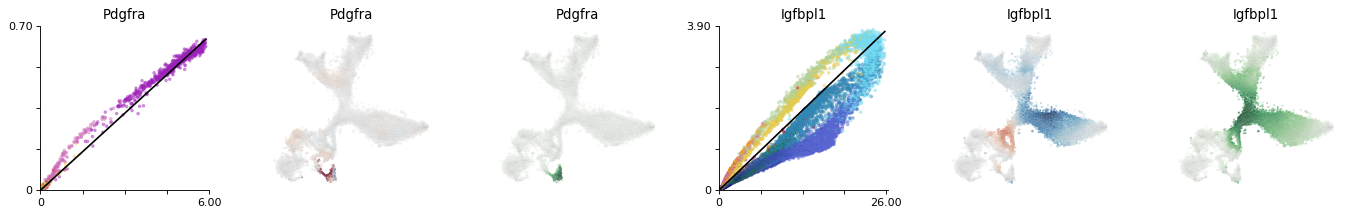

In [792]:
plt.figure(None, (17,2.8), dpi=80)
gs = plt.GridSpec(1,6)
for i, gn in enumerate(["Pdgfra","Igfbpl1"]):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], c=vlm.colorandum, s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
    plt.ylim(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    minimal_yticks(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    minimal_xticks(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    despline()
    
    vlm.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)

    vlm.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    
plt.tight_layout()
plt.savefig("../figures/Fig3_selection.pdf")

2018-05-13 11:49:28,433 - DEBUG - Assigning font /b'F1' = '/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2018-05-13 11:49:36,281 - DEBUG - Embedding font /data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2018-05-13 11:49:36,282 - DEBUG - Writing TrueType font.


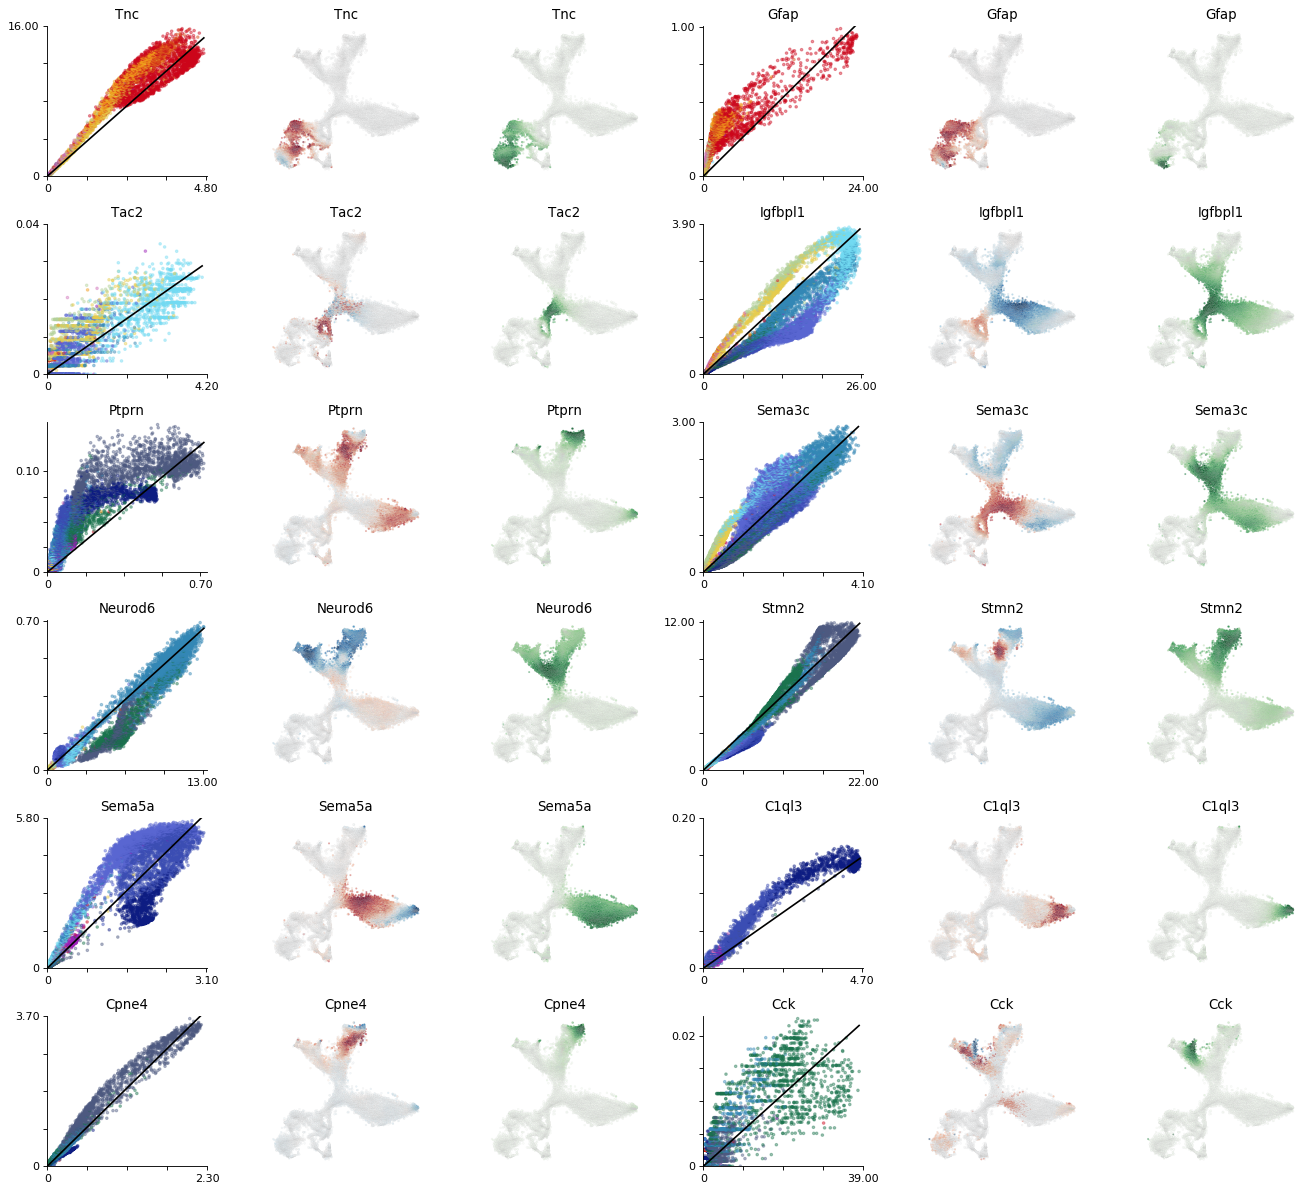

In [793]:
plt.figure(None, (16.5,15), dpi=80)
gs = plt.GridSpec(6,6)
for i, gn in enumerate(["Tnc", "Gfap", "Tac2","Igfbpl1", 'Ptprn',
                        "Sema3c", "Neurod6", "Stmn2", "Sema5a", "C1ql3", "Cpne4", "Cck"]):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], c=vlm.colorandum, s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
    plt.ylim(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    minimal_yticks(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    minimal_xticks(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    despline()
    
    vlm.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)

    vlm.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    
plt.tight_layout()
plt.savefig("../figures/Suppl_phase_selection.pdf")

In [797]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_neighbors=2000, knn_random=True, sampled_fraction=0.5)

2018-05-13 11:50:47,134 - DEBUG - Calculate KNN in the embedding space
2018-05-13 11:51:01,582 - DEBUG - Correlation Calculation 'knn_random'
2018-05-13 11:52:15,569 - DEBUG - Done Correlation Calculation


In [798]:
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
vlm.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=300)

2018-05-13 11:52:15,578 - DEBUG - Calculate transition probability
2018-05-13 11:52:18,593 - DEBUG - Calculate transition probability for negative control


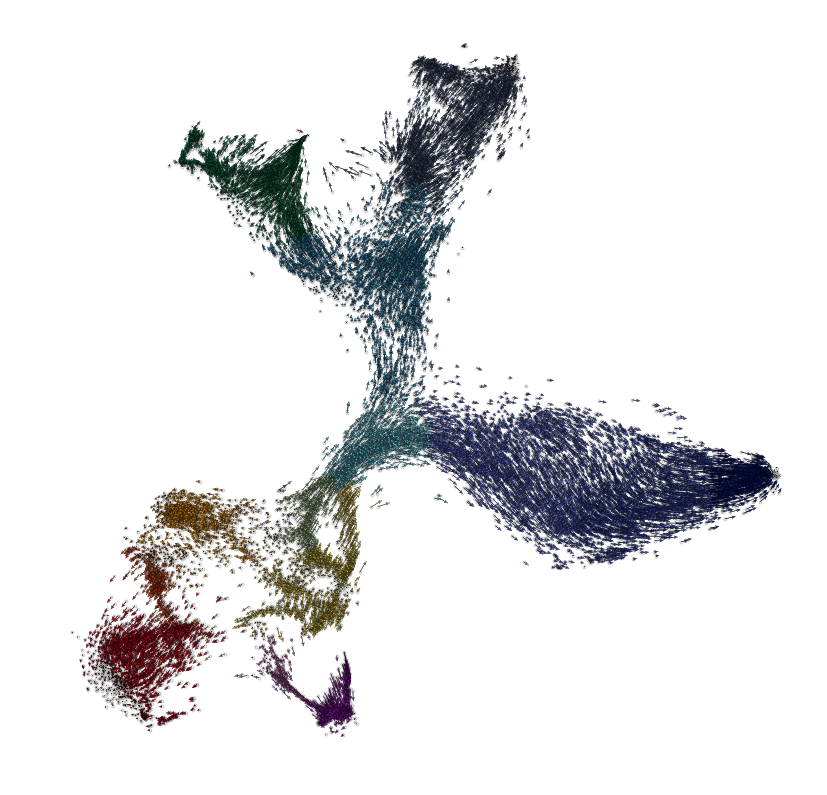

In [799]:
plt.figure(None,(14,14))
quiver_scale = 60

plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color=vlm.colorandum[ix_choice], alpha=1)
plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")
plt.savefig("../figures/full_arrows.pdf")

2018-05-13 12:06:51,579 - WARNING - The arrow scale was set to be 'absolute' make sure you know how to properly interpret the plots
2018-05-13 12:06:52,057 - DEBUG - Assigning font /b'F1' = '/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2018-05-13 12:06:52,528 - DEBUG - Embedding font /data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2018-05-13 12:06:52,529 - DEBUG - Writing TrueType font.


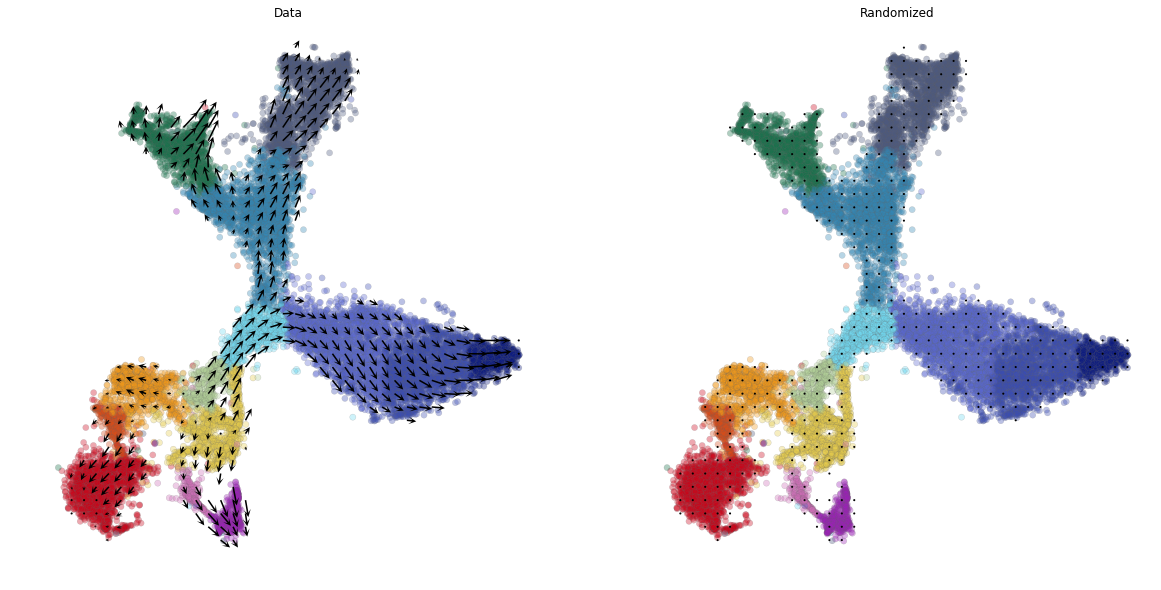

In [804]:
# initial divide by mean
plt.figure(None,(20,10))
vlm.plot_grid_arrows(quiver_scale=0.48,
                     scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, min_mass=24, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, minlength=1.5,
                     plot_random=True, scale_type="absolute")
plt.savefig("../figures/vectorfield.pdf")

# Produce non default plots

In [23]:
def gaussian_kernel(X, mu = 0, sigma=1):
    return np.exp(-(X - mu)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

In [27]:
from scipy.stats import norm
from sklearn.neighbors import NearestNeighbors

2018-05-13 11:42:06,756 - DEBUG - Assigning font /b'F1' = '/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2018-05-13 11:42:06,778 - DEBUG - Embedding font /data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2018-05-13 11:42:06,779 - DEBUG - Writing TrueType font.


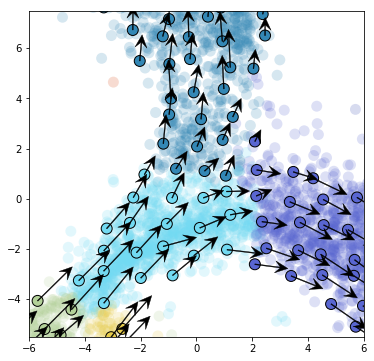

In [785]:
plt.figure(None,(6,6))

steps = 45, 45
grs = []
for dim_i in range(vlm.embedding.shape[1]):
    m, M = np.min(vlm.embedding[:, dim_i]), np.max(vlm.embedding[:, dim_i])
    m = m - 0.025 * np.abs(M - m)
    M = M + 0.025 * np.abs(M - m)
    gr = np.linspace(m, M, steps[dim_i])
    grs.append(gr)

meshes_tuple = np.meshgrid(*grs)
gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T
gridpoints_coordinates = gridpoints_coordinates + norm.rvs(loc=0, scale=0.15, size=gridpoints_coordinates.shape)

nn = NearestNeighbors()
nn.fit(vlm.embedding)
dist, ixs = nn.kneighbors(gridpoints_coordinates, 20)
ix_choice = ixs[:,0].flat[:]
ix_choice = np.unique(ix_choice)

nn = NearestNeighbors()
nn.fit(vlm.embedding)
dist, ixs = nn.kneighbors(vlm.embedding[ix_choice], 20)
density_extimate = gaussian_kernel(dist, mu=0, sigma=0.5).sum(1)
bool_density = density_extimate > np.percentile(density_extimate, 25)
ix_choice = ix_choice[bool_density]

plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c=vlm.colorandum, alpha=0.2, s=120, edgecolor="")
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c=vlm.colorandum[ix_choice], alpha=1, s=120, edgecolor="k")

quiver_kwargs=dict(scale=6.8, headaxislength=9, headlength=15, headwidth=14,linewidths=0.4, edgecolors="k", color="k", alpha=1)
plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           **quiver_kwargs)

plt.xlim(-6.,6) 
plt.ylim(-5.5,7.5)
plt.savefig("../figures/grid_arrows_neuro.pdf")

2018-05-13 11:43:06,759 - DEBUG - Assigning font /b'F1' = '/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2018-05-13 11:43:06,784 - DEBUG - Embedding font /data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2018-05-13 11:43:06,784 - DEBUG - Writing TrueType font.


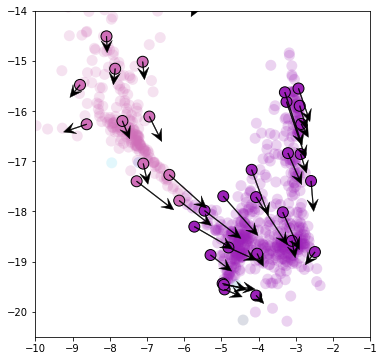

In [789]:
plt.figure(None,(6,6))

steps = 55, 55
grs = []
for dim_i in range(vlm.embedding.shape[1]):
    m, M = np.min(vlm.embedding[:, dim_i]), np.max(vlm.embedding[:, dim_i])
    m = m - 0.025 * np.abs(M - m)
    M = M + 0.025 * np.abs(M - m)
    gr = np.linspace(m, M, steps[dim_i])
    grs.append(gr)

meshes_tuple = np.meshgrid(*grs)
gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T
gridpoints_coordinates = gridpoints_coordinates + norm.rvs(loc=0, scale=0.15, size=gridpoints_coordinates.shape)

from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors()
nn.fit(vlm.embedding)
dist, ixs = nn.kneighbors(gridpoints_coordinates, 20)
ix_choice = ixs[:,0].flat[:]
ix_choice = np.unique(ix_choice)

nn = NearestNeighbors()
nn.fit(vlm.embedding)
dist, ixs = nn.kneighbors(vlm.embedding[ix_choice], 20)
density_extimate = gaussian_kernel(dist, mu=0, sigma=0.5).sum(1)
bool_density = density_extimate > np.percentile(density_extimate, 30)
ix_choice = ix_choice[bool_density]

plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c=vlm.colorandum, alpha=0.2, s=120, edgecolor="")

plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c=vlm.colorandum[ix_choice], alpha=1, s=120, edgecolor="k")

quiver_kwargs=dict(scale=6.8, headaxislength=9, headlength=15, headwidth=14,linewidths=0.4, edgecolors="k", color="k", alpha=1)
#quiver_kwargs=dict(headaxislength=8, headlength=10, headwidth=1,linewidths=0.1, edgecolors="k", color=self.colorandum[ix_choice])


plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           **quiver_kwargs)

plt.xlim(-10,-1)
plt.ylim(-20.5,-14)
plt.savefig("../figures/grid_arrows_oligos.pdf")


In [806]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_neighbors=4000, knn_random=True, sampled_fraction=0.98, calculate_randomized=False)

2018-05-13 12:09:02,414 - DEBUG - Calculate KNN in the embedding space
2018-05-13 12:09:46,574 - DEBUG - Correlation Calculation 'knn_random'
2018-05-13 12:14:00,279 - DEBUG - Done Correlation Calculation


In [807]:
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)

2018-05-13 12:14:00,289 - DEBUG - Calculate transition probability
2018-05-13 12:14:03,768 - DEBUG - Calculate transition probability for negative control


In [808]:
transition_probs = np.copy(vlm.transition_prob)

9187
12258
2018-05-13 12:32:51,290 - DEBUG - Assigning font /b'F1' = '/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2018-05-13 12:32:51,427 - DEBUG - Embedding font /data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2018-05-13 12:32:51,428 - DEBUG - Writing TrueType font.


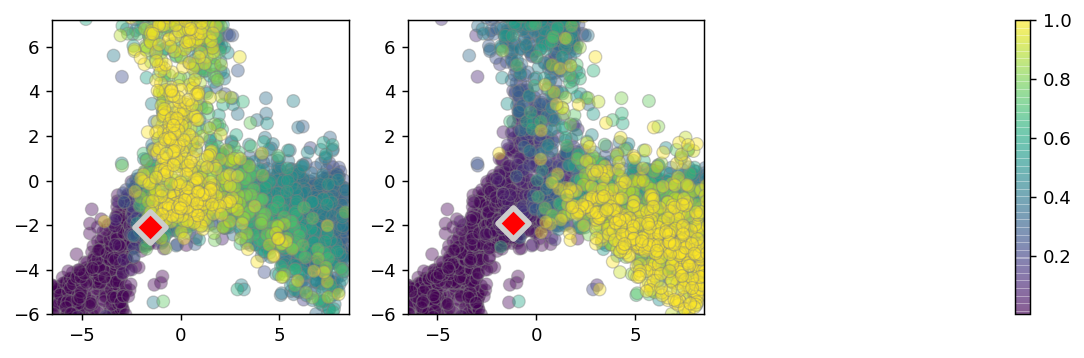

In [815]:
plt.figure(None,(10,3), dpi=130)
plt.subplot(131)
ix1 = 9187
print(ix1)
ix = ix1
neigh_bool = (vlm.embedding_knn[ix,:].A[0] > 0)
colorandum = vlm.transition_prob[ix,:][neigh_bool]
#print(np.percentile(colorandum, 10))
#print(np.percentile(colorandum, 90))
colorandum -= 1e-6 
colorandum = colorandum / 7e-4
colorandum = np.clip(colorandum, 0, 1)
plt.scatter(vlm.embedding[neigh_bool,:][:, 0][np.argsort(colorandum)],
            vlm.embedding[neigh_bool,:][:, 1][np.argsort(colorandum)],
            c=colorandum[np.argsort(colorandum)], 
            cmap=plt.cm.viridis, alpha=0.4, lw=0.7, s=50, edgecolor="0.5", rasterized=True)
plt.scatter(vlm.embedding[ix, 0], vlm.embedding[ix, 1],
            c="r", alpha=1, s=150, lw=3, edgecolor="0.8", marker="D")
plt.xlim(-6.5,8.5) 
plt.ylim(-6,7.2)


plt.subplot(132)
ix2 = 12258 
print(ix2)
ix = ix2

neigh_bool = (vlm.embedding_knn[ix,:].A[0] > 0)
colorandum = vlm.transition_prob[ix,:][neigh_bool]
#print(np.percentile(colorandum, 10))
#print(np.percentile(colorandum, 90))
colorandum -= 1e-6
colorandum = colorandum / 7e-4
colorandum = np.clip(colorandum, 0, 1)

ax = plt.scatter(vlm.embedding[neigh_bool,:][:, 0][np.argsort(colorandum)],
                 vlm.embedding[neigh_bool,:][:, 1][np.argsort(colorandum)],
                 c=colorandum[np.argsort(colorandum)], 
                 cmap=plt.cm.viridis, alpha=0.4, lw=0.7, s=50, edgecolor="0.5", rasterized=True)

plt.scatter(vlm.embedding[ix, 0], vlm.embedding[ix, 1],
            c="r", alpha=1, s=150, lw=3, edgecolor="0.8", marker="D")
plt.xlim(-6.5,8.5) 
plt.ylim(-6,7.2)

plt.subplot(133)
plt.colorbar(ax)
plt.axis("off")
plt.savefig("../figures/Fig3_neuro_tp.pdf")

0.00010687063518881769
0.0004985341416446812
1.934112160004972e-05
0.0008293442724157537
2018-05-13 12:22:53,419 - DEBUG - Assigning font /b'F1' = '/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2018-05-13 12:22:53,549 - DEBUG - Embedding font /data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2018-05-13 12:22:53,550 - DEBUG - Writing TrueType font.


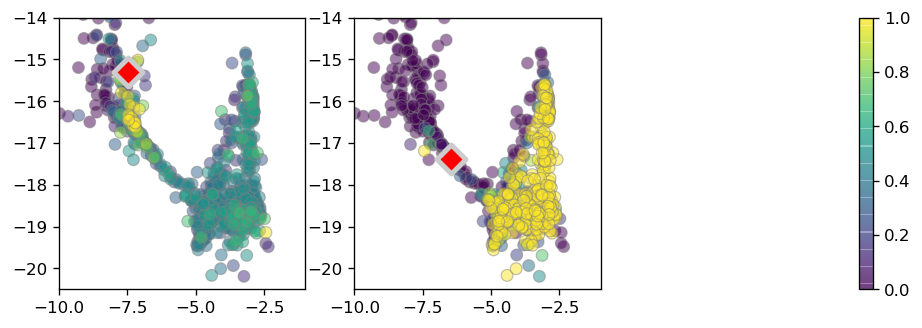

In [814]:
plt.figure(None,(9,3), dpi=120)
plt.subplot(131)
ix1 = 15608 # 4563


ix = ix1
neigh_bool = (vlm.embedding_knn[ix,:].A[0] > 0)
colorandum = vlm.transition_prob[ix,:][neigh_bool]
print(np.percentile(colorandum, 10))
print(np.percentile(colorandum, 90))
colorandum -= 2e-4 
colorandum = colorandum / 7e-4
colorandum = np.clip(colorandum, 0, 1)
plt.scatter(vlm.embedding[neigh_bool,:][:, 0][np.argsort(colorandum)],
            vlm.embedding[neigh_bool,:][:, 1][np.argsort(colorandum)],
            c=colorandum[np.argsort(colorandum)], 
            cmap=plt.cm.viridis, alpha=0.5, lw=0.7, s=50, edgecolor="0.5", rasterized=True)
plt.scatter(vlm.embedding[ix, 0], vlm.embedding[ix, 1],
            c="r", alpha=1, s=150, lw=3, edgecolor="0.8", marker="D")
plt.xlim(-10,-1)
plt.ylim(-20.5,-14)

plt.subplot(132)
ix2 = 10977
ix = ix2

neigh_bool = (vlm.embedding_knn[ix,:].A[0] > 0)
colorandum = vlm.transition_prob[ix,:][neigh_bool]
print(np.percentile(colorandum, 10))
print(np.percentile(colorandum, 90))
colorandum -= 2e-4
colorandum = colorandum / 7e-4
colorandum = np.clip(colorandum, 0, 1)
ax = plt.scatter(vlm.embedding[neigh_bool,:][:, 0][np.argsort(colorandum)],
                 vlm.embedding[neigh_bool,:][:, 1][np.argsort(colorandum)],
                 c=colorandum[np.argsort(colorandum)], 
                 cmap=plt.cm.viridis, alpha=0.5, lw=0.7, s=50, edgecolor="0.5", rasterized=True)
#plt.colorbar()
plt.scatter(vlm.embedding[ix, 0], vlm.embedding[ix, 1],
            c="r", alpha=1, s=150, lw=3, edgecolor="0.8", marker="D")
plt.xlim(-10,-1)
plt.ylim(-20.5,-14)
plt.subplot(133)
plt.colorbar(ax)
plt.axis("off")
plt.savefig("../figures/Fig3_oligos_tp.pdf")

## Markov chain

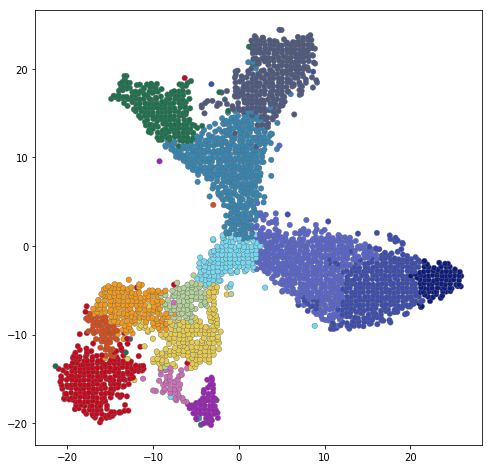

In [769]:
# Sample uniformly the points to avoid density driven effects - Should reimplement as a method
steps = 100, 100
grs = []
for dim_i in range(vlm.embedding.shape[1]):
    m, M = np.min(vlm.embedding[:, dim_i]), np.max(vlm.embedding[:, dim_i])
    m = m - 0.025 * np.abs(M - m)
    M = M + 0.025 * np.abs(M - m)
    gr = np.linspace(m, M, steps[dim_i])
    grs.append(gr)

meshes_tuple = np.meshgrid(*grs)
gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T

from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors()
nn.fit(vlm.embedding)
dist, ixs = nn.kneighbors(gridpoints_coordinates, 1)

diag_step_dist = np.sqrt((meshes_tuple[0][0,0] - meshes_tuple[0][0,1])**2 + (meshes_tuple[1][0,0] - meshes_tuple[1][1,0])**2)
min_dist = diag_step_dist / 2
ixs = ixs[dist < min_dist]
gridpoints_coordinates = gridpoints_coordinates[dist.flat[:]<min_dist,:]
dist = dist[dist < min_dist]

ixs = np.unique(ixs)

plt.figure(None,(8,8))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=vlm.colorandum[ixs], alpha=1, s=30, lw=0.4,
                edgecolor="0.4")

In [775]:
vlm.prepare_markov(sigma_D=diag_step_dist, sigma_W=diag_step_dist/2., direction='forward', cells_ixs=ixs)

In [776]:
vlm.run_markov(starting_p=np.ones(len(ixs)), n_steps=2500)

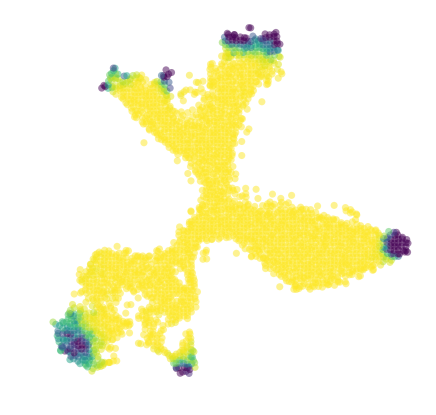

In [779]:
diffused_n = vlm.diffused - np.percentile(vlm.diffused, 3)
diffused_n /= np.percentile(diffused_n, 97)
diffused_n = np.clip(diffused_n, 0, 1)

plt.figure(None,(7,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.5, s=50, lw=0.,
                edgecolor="", cmap="viridis_r", rasterized=True)
plt.axis("off")
plt.savefig("../figures/endpoint_distr_.pdf")

In [780]:
vlm.prepare_markov(sigma_D=diag_step_dist, sigma_W=diag_step_dist/2., direction='backwards', cells_ixs=ixs)
vlm.run_markov(starting_p=np.ones(len(ixs)), n_steps=2500)

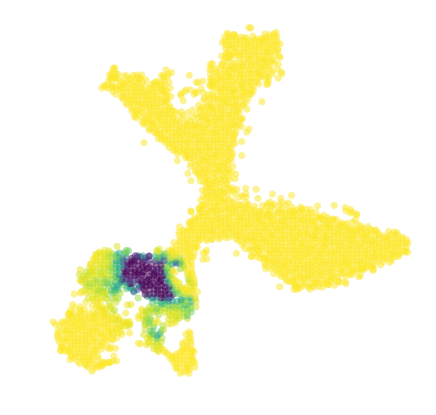

In [781]:
diffused_n = vlm.diffused - np.percentile(vlm.diffused, 3)
diffused_n /= np.percentile(diffused_n, 97)
diffused_n = np.clip(diffused_n, 0, 1)

plt.figure(None,(7,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.5, s=50, lw=0.,
                edgecolor="", cmap="viridis_r", rasterized=True)
plt.axis("off")
plt.savefig("../figures/startpoint_distr_.pdf")